# Volume Cutoff

Streamlined notebook for evaluating volume cutoffson saved models and datasets.

## Imports

In [1]:
# Standard library
import os
import sys
import time
import json

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.perturb_funcs import ( cumulative_average_loss_curve )

from minima_volume.dataset_funcs import (
    load_dataset,
    load_model,
    load_models_and_data,
    prepare_datasets,
    tensor_to_list,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model + Dataset Specific Code

This is for model and dataset specific code.

In [2]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

#test_dataset_size = 2000

# Generate dataset - Not used in random perturbs
#x_base, y_base, x_test, y_test = model_module.get_dataset(
#    base_data_size=base_data_size,
#    dataset_quantities=dataset_quantities,
#    test_dataset_size=test_dataset_size,
#    noise=0.3, # default swiss params
#    extra_pts=1000,
#    dataset_type=dataset_type,
#    seed=data_seed
#)
model_seed = 0 # filler for the template

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn_per_sample = model_module.get_loss_fn_per_sample()
#other_metrics = model_module.get_additional_metrics()

## Loading Model and Datasets

In [3]:
# ====================================
# Load Trained Models and Dataset
# ====================================
target_dir = "models_and_data"  # relative path
loaded_models, loaded_model_data, loaded_dataset = load_models_and_data(
    model_template=model_template,
    target_dir=target_dir,
    device=device,
)

# Dataset Info
dataset_type = loaded_dataset['dataset_type']
dataset_quantities = loaded_dataset['dataset_quantities']
print(f"Dataset type: {dataset_type}")
print(f"Dataset quantities: {loaded_dataset['dataset_quantities']}")

print("\nTensor shapes:")
for key in ["x_base_train", "y_base_train", "x_additional", "y_additional", "x_test", "y_test"]:
    shape = getattr(loaded_dataset[key], "shape", None)
    print(f"  {key}: {shape if shape is not None else 'None'}")

# Reconstruct trained_model dicts safely.
# If the loss or accuracy or additional metrics happen to be
# tensors, they get safely converted to lists.
all_models = [
    {
        "model": model,
        **{
            k: tensor_to_list(model_data[k], key_path=k)
            for k in ["train_loss", "train_accs", "test_loss", "test_accs", "additional_data", "dataset_type"]
        },
    }
    for model, model_data in zip(loaded_models, loaded_model_data)
]
print(f"Reconstructed {len(all_models)} trained models")

Looking for models and dataset in: models_and_data
Found 5 model files:
  - model_additional_0.pt
  - model_additional_10.pt
  - model_additional_100.pt
  - model_additional_20.pt
  - model_additional_50.pt
✅ Model loaded into provided instance from models_and_data\model_additional_0.pt
Successfully loaded: model_additional_0.pt
✅ Model loaded into provided instance from models_and_data\model_additional_10.pt
Successfully loaded: model_additional_10.pt
✅ Model loaded into provided instance from models_and_data\model_additional_100.pt
Successfully loaded: model_additional_100.pt
✅ Model loaded into provided instance from models_and_data\model_additional_20.pt
Successfully loaded: model_additional_20.pt
✅ Model loaded into provided instance from models_and_data\model_additional_50.pt
Successfully loaded: model_additional_50.pt

Model data loaded from all models:
Model 0 (model_additional_0.pt):
  - Additional data: 0
  - Dataset type: poison
  - Training accuracies: 500 entries
  - Test 

## Loss Cutoff Computation


Evaluating full dataset of size 500 for all models...
Saved cumulative loss curves JSON to: cutoffs\cutoffs.json


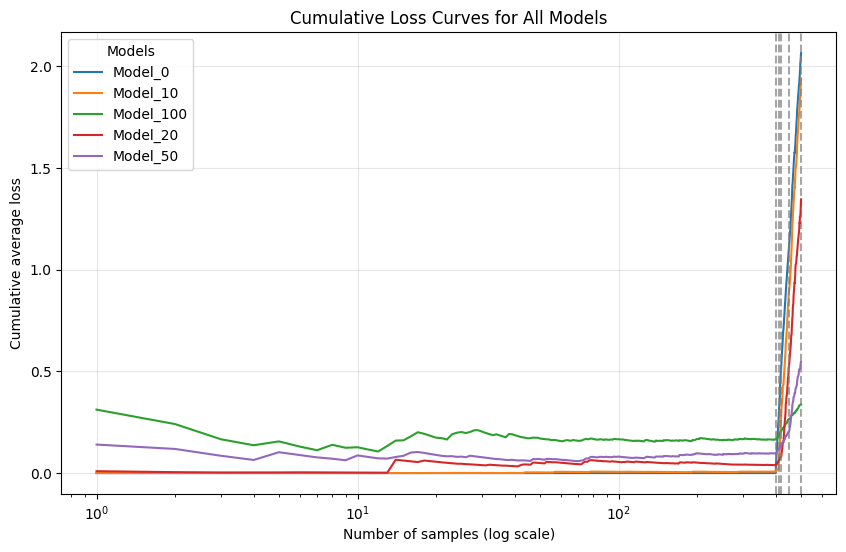

Saved cumulative loss curves plot to: cutoffs\loss_curves.png


In [4]:
# -------------------------------
# 1. Build the full dataset once
# -------------------------------
# Explicitly extract tensors from the loaded dataset
x_base_train = loaded_dataset.get("x_base_train", None)
y_base_train = loaded_dataset.get("y_base_train", None)
x_additional = loaded_dataset.get("x_additional", None)
y_additional = loaded_dataset.get("y_additional", None)
x_test = loaded_dataset.get("x_test", None)
y_test = loaded_dataset.get("y_test", None)

max_additional = max(dataset_quantities)  # maximum additional data used across models
x_full = torch.cat([x_base_train, x_additional[:max_additional]], dim=0)
y_full = torch.cat([y_base_train, y_additional[:max_additional]], dim=0)

print(f"\nEvaluating full dataset of size {len(x_full)} for all models...")

# Ensure the output folder exists
os.makedirs("cutoffs", exist_ok=True)

# -------------------------------
# 2. Compute cumulative loss curves
# -------------------------------
cutoff_results = {}
base_train_size = len(x_base_train)  # size of the base training data

for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    # Compute cumulative average loss curve
    # Note: loss_fn_per_sample must return per-sample losses (shape [batch_size])
    curve = cumulative_average_loss_curve(model, x_full, y_full, loss_fn_per_sample)

    # Indices (1-based) for plotting
    indices = list(range(1, len(curve) + 1))

    # Store results in dictionary for JSON saving
    cutoff_results[f"Model_{additional_data}"] = {
        "additional_data": additional_data,
        "base_train_size": base_train_size,
        "indices": indices,
        "loss_curve": curve.tolist()
    }

# -------------------------------
# 3. Save JSON results
# -------------------------------
json_path = os.path.join("cutoffs", "cutoffs.json")
with open(json_path, "w") as f:
    json.dump(cutoff_results, f, indent=2)

print(f"Saved cumulative loss curves JSON to: {json_path}")

# -------------------------------
# 4. Plot cumulative loss curves
# -------------------------------
plot_path = os.path.join("cutoffs", "loss_curves.png")
plt.figure(figsize=(10, 6))

for model_name, data in cutoff_results.items():
    indices = data["indices"]
    loss_curve = data["loss_curve"]
    additional_data = data["additional_data"]
    base_train_size = data["base_train_size"]

    # Plot the cumulative average loss curve
    plt.plot(indices, loss_curve, label=model_name)

    # Add vertical line indicating the dataset size that model was trained on
    train_size = base_train_size + additional_data
    plt.axvline(train_size, color="gray", linestyle="--", alpha=0.7)

# Configure plot aesthetics
plt.xscale("log")
plt.xlabel("Number of samples (log scale)")
plt.ylabel("Cumulative average loss")
plt.title("Cumulative Loss Curves for All Models")
plt.legend(title="Models")
plt.grid(True, alpha=0.3)

# Save the figure
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"Saved cumulative loss curves plot to: {plot_path}")
